# Random Forest for Board Game Success

Having tried to model the success of board games in my sample using a logistic regression, I found that the best results were obtained using an over-sampling method called SMOTE, with somewhat similar results with an ensemble under-sampling approach. Another useful classifier is the random forest, which is in itself an ensemble approach, but with decision trees instead of regression classifiers. Random forests may not be as easily interpretable as the logistic regression, but it tends to have superior accuracy and therefore worth a try. I will be repeating the approaches from the logistic regression modeling for the random forest, and will explore the results in this notebook.

## Simple Random Forest

Since we will be comparing to the logistic regression, let's start out simple. Just like with logistic regression, I will use the same cutoff point of 80th percentile for success, and try to predict without any attempt to balance the dataset. I can start by loading in the data and creating the same features and target as in the logistic regression notebook:

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

with open('BGG_NoNaN_DF.pkl', 'rb') as f:
    noNaN_DF = pickle.load(f)

ratings = noNaN_DF['Rating']
ratings80 = np.percentile(noNaN_DF['Rating'], 80)
target = ratings.apply(lambda x: x >= ratings80)
features = noNaN_DF.drop(['Rating', 'ID Num', 'User Number', 'Standard Dev'], axis=1)
print(target.shape, features.shape)

(17521,) (17521, 6)


Now we can just use an out of the box random forest classifier from sklearn:

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Split the data with a 70-30 train-test split, then do a grid search:
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, 
                                                    test_size=0.3, random_state=42)
n_estimates = [150, 200, 250]
max_feats = [2, 3, 4]
max_depth = [1, 2, 3]
randfor = RandomForestClassifier(random_state=42)
clf_grid = GridSearchCV(randfor, {'n_estimators': n_estimates, 'max_features': max_feats, 'max_depth': max_depth}
                        , cv=5, scoring='accuracy')
clf_grid.fit(X_train, y_train)

# Predict on the test (and training) set to calculate metrics:
y_predict_train = clf_grid.predict(X_train)
y_predict_test = clf_grid.predict(X_test)

print('Best parameters for n_estimators, max_features, and max_depth: \n')
print(clf_grid.best_params_, clf_grid.best_score_)
print('\nAccuracy Score:')
print(accuracy_score(y_predict_test, y_test))
print('\nConfusion Matrix')
print(confusion_matrix(y_predict_test, y_test))

print("\n[Training Classification Report:]")
print(classification_report(y_train, y_predict_train))

print("[Test Classification Report:]")
print(classification_report(y_test, y_predict_test))

Best parameters for n_estimators, max_features, and max_depth: 

{'max_depth': 1, 'max_features': 2, 'n_estimators': 150} 0.8030821917808217

Accuracy Score:
0.7926574091687274

Confusion Matrix
[[4167 1090]
 [   0    0]]

[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.80      1.00      0.89      9849
       True       0.00      0.00      0.00      2415

avg / total       0.64      0.80      0.72     12264

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.79      1.00      0.88      4167
       True       0.00      0.00      0.00      1090

avg / total       0.63      0.79      0.70      5257



/Users/danielfeldman/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Just like with the logistic regression classifier, the random forest is experiencing the same problem typically seen with imbalanced datasets. That is, the majority class is swamping out the minority class, and so the classifier will just say everything is the majority class. As such, I think it'll be good to try to balance the dataset out in the ways similar to how I did it in the logistic regression notebook.

## Using SMOTE to create synthetic samples of the minority class

SMOTE is a good way to generate synthetic samples of the minority class by taking real samples and perturbing the values in the direction of the other real samples of the minority class. This can be used to make a balanced sample for classification. 

In [3]:
from imblearn.over_sampling import SMOTE

# Establish data set features and target:
X_before = features.values
y_before = target.values

# Do a train-test split of 70-30 on the new dataset:
X_train_before, X_test_res, y_train_before, y_test_res = train_test_split(X_before, y_before, 
                                                test_size=0.3, random_state=42)

# There are 4 different SMOTE algorithms, so let's try each one:
kinds = ['regular', 'borderline1', 'borderline2', 'svm']
for k in kinds:
    
    # Use SMOTE to generate synthetic samples of the minority class:
    sm = SMOTE(kind=k, random_state=42)  # Without an input ratio, will generate until equal representation
    X_train_res, y_train_res = sm.fit_sample(X_train_before, y_train_before)
    print(X_train_res.shape)
    print('SMOTE Algorithm: {}'.format(k))
    print('--------------------------------------')
    
    # Train the random forest classifier using the same grid search as before:
    randfor = RandomForestClassifier(random_state=42)
    clf_smote = GridSearchCV(randfor, {'n_estimators': n_estimates, 'max_features': max_feats, 'max_depth': max_depth}
                            , cv=5, scoring='accuracy')
    clf_smote.fit(X_train_res, y_train_res)
    
    # Predict using best results then calculate the metrics:
    y_predict_train_res = clf_smote.predict(X_train_res)
    y_predict_test_res = clf_smote.predict(X_test_res)
    
    accuracy = accuracy_score(y_predict_test_res, y_test_res)
    print('Accuracy score: {}\n'.format(accuracy))
    print(confusion_matrix(y_predict_test_res, y_test_res))
    print('\n')
    print("[Training Classification Report:]")
    print(classification_report(y_train_res, y_predict_train_res))
    
    print("[Test Classification Report:]")
    print(classification_report(y_test_res, y_predict_test_res))

(19698, 6)
SMOTE Algorithm: regular
--------------------------------------
Accuracy score: 0.6851816625451779

[[2885  373]
 [1282  717]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.70      0.70      0.70      9849
       True       0.70      0.70      0.70      9849

avg / total       0.70      0.70      0.70     19698

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.89      0.69      0.78      4167
       True       0.36      0.66      0.46      1090

avg / total       0.78      0.69      0.71      5257

(19698, 6)
SMOTE Algorithm: borderline1
--------------------------------------
Accuracy score: 0.6867034430283432

[[2898  378]
 [1269  712]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.69      0.70      0.70      9849
       True       0.70      0.69      0.69      9849

avg / total       0.69     

In [4]:
print('Best parameters for n_estimators, max_features, and max_depth: \n')
print(clf_smote.best_params_, clf_smote.best_score_)

Best parameters for n_estimators, max_features, and max_depth: 

{'max_depth': 3, 'max_features': 2, 'n_estimators': 250} 0.7294004163070519


The results for SMOTE appear similar to that of logistic regression, though with slightly better results. In this case, the top two are the "SVM" and "Borderline-1" algorithms. Generally however, they all performed roughly just as well.

The precision is very low for the True class, but that's mostly because of the total numbers; because so many of the games are in the false class, there will be more false positives than true positives even if the false recall is high. However, it's worth looking deeper into the precision. In this case, positives are in the top 20% of all games...of the board games considered false positives, where do they lie?

In [5]:
# Get the ratings for the test set used in the last SMOTE algorithm:
_, X_test_res, __, y_test_rate = train_test_split(X_before, ratings.values, 
                                                test_size=0.3, random_state=42)

print(y_predict_test_res)
test_true_ind = np.where(y_predict_test_res==True)[0]
print(test_true_ind)
ratings_true = y_test_rate[test_true_ind]

[False  True False ...  True False False]
[   1    5    6 ... 5247 5248 5254]


In [6]:
print(ratings_true.max(), ratings_true.min())

8.31081 5.15607


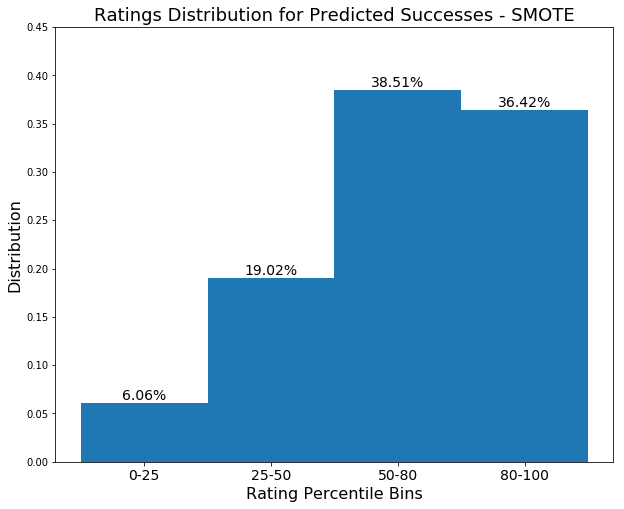

In [19]:
hist = np.histogram(ratings_true, bins=(np.percentile(noNaN_DF.Rating, 0),
                                        np.percentile(noNaN_DF.Rating, 25),
                                        np.percentile(noNaN_DF.Rating, 50),
                                        np.percentile(noNaN_DF.Rating, 80),
                                        np.percentile(noNaN_DF.Rating, 100)))
percents = hist[0]/np.sum(hist[0])
fig, axes = plt.subplots(figsize=(10,8))
rects = axes.bar(range(4), percents, width=1)
xticks = ['0-25', '25-50', '50-80', '80-100']
for rect in rects:
    height = float(rect.get_height())
    _ = axes.text(rect.get_x() + rect.get_width()/2., 1.001*height,
                '{:.2f}%'.format(height*100), ha='center', va='bottom', size=14)
_ = plt.xticks(np.arange(0,4), xticks, size=14)
_ = axes.set_xlabel('Rating Percentile Bins', fontsize=16)
_ = axes.set_ylabel('Distribution', fontsize=16)
_ = axes.set_ylim([0.0, 0.45])
_ = plt.title('Ratings Distribution for Predicted Successes - SMOTE', fontsize=18)
plt.show()

Games in the 80-100th percentile bin are the ones considered successful to the model, but if you assume ratings correlate to monetary gain, then anything in the two right-most bins would be at least somewhat lucrative. Let's see a more stratified version of this plot:

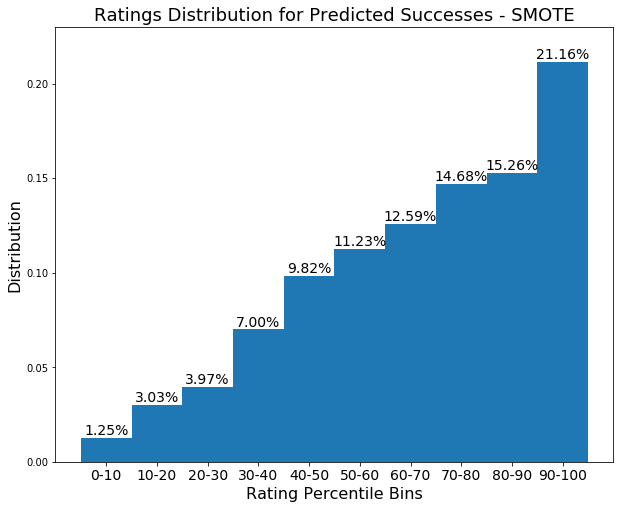

In [9]:
hist = np.histogram(ratings_true, bins=(np.percentile(noNaN_DF.Rating, 0),np.percentile(noNaN_DF.Rating, 10),
                                   np.percentile(noNaN_DF.Rating, 20),np.percentile(noNaN_DF.Rating, 30),
                                   np.percentile(noNaN_DF.Rating, 40),np.percentile(noNaN_DF.Rating, 50),
                                   np.percentile(noNaN_DF.Rating, 60),np.percentile(noNaN_DF.Rating, 70),
                                   np.percentile(noNaN_DF.Rating, 80),np.percentile(noNaN_DF.Rating, 90),
                                   np.percentile(noNaN_DF.Rating, 100)))
percents = hist[0]/np.sum(hist[0])
fig, axes = plt.subplots(figsize=(10,8))
#_ = axes.hist(ratings_true_pred, bins=[5,5.524,5.581,5.84,8.1])
rects = axes.bar(range(0,40,4), percents, width=4)
xticks = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80',
          '80-90', '90-100']
for rect in rects:
    height = float(rect.get_height())
    _ = axes.text(rect.get_x() + rect.get_width()/2., 1.001*height,
                '{:.2f}%'.format(height*100), ha='center', va='bottom', size=14)
_ = plt.xticks(np.arange(0,40,4), xticks, size=14)
_ = axes.set_xlabel('Rating Percentile Bins', fontsize=16)
_ = axes.set_ylabel('Distribution', fontsize=16)
_ = axes.set_ylim([0.0, 0.23])
_ = plt.title('Ratings Distribution for Predicted Successes - SMOTE', fontsize=18)
plt.show()

Given the skew to the right side of the plot, these are very good results for the random forest classifier. Given a potential client wanting to use this model for predicting success, if they green-light only games considered successful, then assuming higher ratings mean higher profits, then this is not a risky model to use. Let's see how under-sampling performs.

## Under-sampling the majority class--ensemble classifier

In the logistic regression notebook, I under-sampled via an ensemble classifier that under-sampled the majority class at random and took a weighted majority vote. It's worth trying this out for the random forest algorithm and seeing if it gives similar (or better) results. Unlike with logistic regression, however, I will use the Out-Of-Bag (OOB) score instead of accuracy score in order to determine how to weigh each vote.

In [16]:
from sklearn.externals import joblib  # For pickling/unpickling models for saving

def accuracy_weighting(accuracy, vote):
    """
    Determines the vote of a classifier based on its accuracy and
    previous vote (0 or 1). If the vote was a 1, make it the 
    accuracy value instead. If a 0, do one minus the accuracy.
    """
    if vote:
        new_vote = accuracy
    else:
        new_vote = 1.0 - accuracy
    return new_vote

# First, let's separate out the different classes in the dataset:
target.name = 'Target'
#noNaN_DF = pd.concat([noNaN_DF, target], axis=1)
trues = noNaN_DF.loc[noNaN_DF.Target==True]
falses = noNaN_DF.loc[noNaN_DF.Target==False]
trues_y = trues['Target']
trues_X = trues.drop(['ID Num', 'User Number', 'Rating', 'Standard Dev', 'Target'], axis=1)
falses_y = falses['Target']
falses_X = falses.drop(['ID Num', 'User Number', 'Rating', 'Standard Dev', 'Target'], axis=1)

# Do a 80-20 train-test-split on trues and falses to build the test set:
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(trues_X.values, 
                                                    trues_y.values, test_size=0.2, random_state=42)
X_train_false, X_test_false, y_train_false, y_test_false = train_test_split(falses_X.values, 
                                                    falses_y.values, test_size=0.2, random_state=42)
X_test_folds = np.concatenate((X_test_true, X_test_false))
y_test_folds = np.concatenate((y_test_true, y_test_false))

# Given the number of classifiers I'm building, will need a smaller grid to search:
max_depth_rand = [1, 2, 3]

# Now to initialize relevant path and lists:
PKLPATH = 'pkl_files/'
models = []
votes = []

# Build & train classifiers, then have them vote, saving results along the way:
for j in range(1000):
    # Use train-test-split to grab a random 26% assortment of remaining training data:
    X_false_random, _1, y_false_random, _2 = train_test_split(X_train_false, 
                                                    y_train_false, test_size=0.74, random_state=j)
    X_train_random = np.concatenate((X_false_random, X_train_true)) # 3320 False, 3226 True
    y_train_random = np.concatenate((y_false_random, y_train_true))
    
    # Do a grid search to train the log regression model:
    clf_rand = RandomForestClassifier(max_features=2, n_estimators=250, random_state=j, 
                                          oob_score=True, max_depth=3)
    clf_rand.fit(X_train_random, y_train_random)
    
    # Vote (predict) on the test set and then apply weight based on accuracy:
    prediction = clf_rand.predict(X_test_folds)
    vote = np.array(prediction, dtype=float) # Individual vote
    #accuracy = accuracy_score(prediction, y_test_folds)
    acccuracy = clf_rand.oob_score_
    vote_weighted = np.fromiter((accuracy_weighting(accuracy, v) for v in vote), float)
    
    # Save model, then place it and its vote inside the models and votes list for later:
    joblib.dump(clf_rand, '{}rand_forest_ens{}.pkl'.format(PKLPATH, str(j)))
    models.append(joblib.load('{}rand_forest_ens{}.pkl'.format(PKLPATH, str(j))))
    votes.append(vote_weighted)

In [17]:
# Now we have all of the models and votes collected, so we can create the ensemble vote:
ensemble_vote = np.sum(votes, axis=0)
ensemble_predict = np.zeros(len(ensemble_vote), dtype=bool)
for index, vote in enumerate(ensemble_vote):
    if vote >= 500.0:
        ensemble_predict[index] = True

# Finally, let's calculate the relevant metrics:
print('Accuracy for full ensemble: {}\n'.format(accuracy_score(ensemble_predict, y_test_folds)))
print('Confusion Matrix: \n')
print(confusion_matrix(ensemble_predict, y_test_folds))
print('\n')
print("[Test Classification Report:]")
print(classification_report(y_test_folds, ensemble_predict))

Accuracy for full ensemble: 0.6978601997146933

Confusion Matrix: 

[[2006  261]
 [ 798  440]]


[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.88      0.72      0.79      2804
       True       0.36      0.63      0.45       701

avg / total       0.78      0.70      0.72      3505



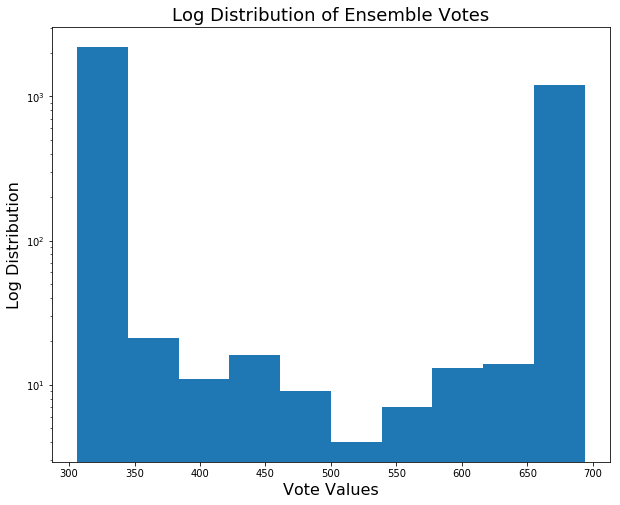

In [18]:
# Plot the distribution of ensemble votes:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.hist(ensemble_vote, bins=10)
_ = axes.set_xlabel('Vote Values', fontsize=16)
_ = axes.set_ylabel('Log Distribution', fontsize=16)
_ = axes.set_yscale('log')
_ = plt.title('Log Distribution of Ensemble Votes', fontsize=18)
plt.show()

In [23]:
trues_y2 = trues['Rating']
falses_y2 = falses['Rating']
X_train_true2, X_test_true2, y_train_true2, y_test_true2 = train_test_split(trues_X.values, 
                                                    trues_y2.values, test_size=0.2, random_state=42)
X_train_false2, X_test_false2, y_train_false2, y_test_false2 = train_test_split(falses_X.values, 
                                                    falses_y2.values, test_size=0.2, random_state=42)
X_test_folds2 = np.concatenate((X_test_true2, X_test_false2))
y_test_folds2 = np.concatenate((y_test_true2, y_test_false2))

ensemble_trues = np.where(ensemble_predict==1)[0]
ratings = y_test_folds2[ensemble_trues]

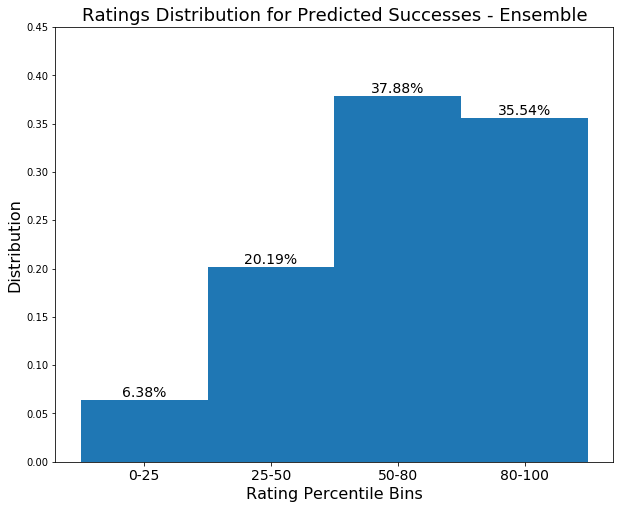

In [25]:
hist = np.histogram(ratings, bins=(np.percentile(noNaN_DF.Rating, 0),
                                        np.percentile(noNaN_DF.Rating, 25),
                                        np.percentile(noNaN_DF.Rating, 50),
                                        np.percentile(noNaN_DF.Rating, 80),
                                        np.percentile(noNaN_DF.Rating, 100)))
percents = hist[0]/np.sum(hist[0])
fig, axes = plt.subplots(figsize=(10,8))
rects = axes.bar(range(4), percents, width=1)
xticks = ['0-25', '25-50', '50-80', '80-100']
for rect in rects:
    height = float(rect.get_height())
    _ = axes.text(rect.get_x() + rect.get_width()/2., 1.001*height,
                '{:.2f}%'.format(height*100), ha='center', va='bottom', size=14)
_ = plt.xticks(np.arange(0,4), xticks, size=14)
_ = axes.set_xlabel('Rating Percentile Bins', fontsize=16)
_ = axes.set_ylabel('Distribution', fontsize=16)
_ = axes.set_ylim([0.0, 0.45])
_ = plt.title('Ratings Distribution for Predicted Successes - Ensemble', fontsize=18)
plt.show()

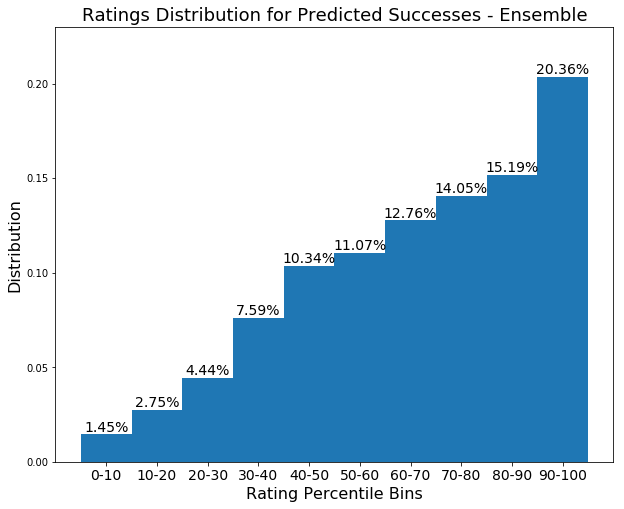

In [26]:
hist = np.histogram(ratings, bins=(np.percentile(noNaN_DF.Rating, 0),np.percentile(noNaN_DF.Rating, 10),
                                   np.percentile(noNaN_DF.Rating, 20),np.percentile(noNaN_DF.Rating, 30),
                                   np.percentile(noNaN_DF.Rating, 40),np.percentile(noNaN_DF.Rating, 50),
                                   np.percentile(noNaN_DF.Rating, 60),np.percentile(noNaN_DF.Rating, 70),
                                   np.percentile(noNaN_DF.Rating, 80),np.percentile(noNaN_DF.Rating, 90),
                                   np.percentile(noNaN_DF.Rating, 100)))
percents = hist[0]/np.sum(hist[0])
fig, axes = plt.subplots(figsize=(10,8))
#_ = axes.hist(ratings_true_pred, bins=[5,5.524,5.581,5.84,8.1])
rects = axes.bar(range(0,40,4), percents, width=4)
xticks = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80',
          '80-90', '90-100']
for rect in rects:
    height = float(rect.get_height())
    _ = axes.text(rect.get_x() + rect.get_width()/2., 1.001*height,
                '{:.2f}%'.format(height*100), ha='center', va='bottom', size=14)
_ = plt.xticks(np.arange(0,40,4), xticks, size=14)
_ = axes.set_xlabel('Rating Percentile Bins', fontsize=16)
_ = axes.set_ylabel('Distribution', fontsize=16)
_ = axes.set_ylim([0.0, 0.23])
_ = plt.title('Ratings Distribution for Predicted Successes - Ensemble', fontsize=18)
plt.show()

The under-sampling method was also a success! Comparing the numbers, it looks very close, though the over-sampling with SMOTE slightly outperformed the under-sampling method. The computation time for over-sampling was also much lower than that of the ensemble method, so while either one can be used, it would appear that over-sampling with random forest is the superior methodology for modeling board game success.